# Regression Tree

In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import graphviz
import matplotlib.pyplot as plt

## Load the data

In [3]:
regression_label = 'habitat_richness'
folder = "../Dataset"
file = "/france_avg.csv"

df = pd.read_csv(folder + file, index_col=['longitude', 'latitude'])
#df = df[df[regression_label] > 0]
y = df[regression_label].values
X = df.drop(columns=[regression_label]).values #returns a numpy array

df.head()

habitat_richness        NDVI  ALBH-AL-BH-NI  \
longitude latitude                                                
3.6       44.43             0.419306  161.000000         1273.0   
          44.44             0.413982  182.166667         1268.0   
          44.45             0.413982  185.666667         1214.0   
          44.46             0.413982  176.777778         1213.0   
          44.47             0.419306  161.166667         1235.0   

                    ALBH-AL-BH-VI  ALBH-AL-BH-BB  ALDH-AL-DH-BB  \
longitude latitude                                                
3.6       44.43            1011.0         1407.0         1821.0   
          44.44            1007.0         1415.0         1799.0   
          44.45             971.0         1441.0         1873.0   
          44.46             971.0         1594.0         1881.0   
          44.47             985.0         1507.0         1962.0   

                    ALDH-AL-DH-NI  FAPAR300-RT0-FAPAR  GDMP300-RT0-GDMP  \
longitude latitude                                                        
3.6       44.43             980.0           33.000000       1492.333333   
          44.44             978.0           33.000000       1545.416667   
          44.45             955.0           11.666667       1674.888889   
          44.46             955.0           22.333333       1559.222222   
          44.47             962.0           81.000000       1378.083333   

                    LAI300-RT0-LAI  ...         ssr        str        sp  \
longitude latitude                  ...                                    
3.6       44.43                7.0  ...  12441340.0 -5370235.5  90567.51   
          44.44                7.0  ...  12441340.0 -5370235.5  90567.51   
          44.45                9.0  ...  12441340.0 -5370235.5  90567.51   
          44.46                8.0  ...  12483643.0 -5230864.5  89168.34   
          44.47                2.5  ...  12483643.0 -5230864.5  89168.34   

                          ssrd        strd        tp    swvl1     swvl2  \
longitude latitude                                                        
3.6       44.43     14720521.0  25503226.0  0.002537  0.33699  0.338934   
          44.44     14720521.0  25503226.0  0.002537  0.33699  0.338934   
          44.45     14720521.0  25503226.0  0.002537  0.33699  0.338934   
          44.46     14626648.0  25360476.0  0.002478  0.43418  0.433668   
          44.47     14626648.0  25360476.0  0.002478  0.43418  0.433668   

                       swvl3     swvl4  
longitude latitude                      
3.6       44.43     0.341503  0.379547  
          44.44     0.341503  0.379547  
          44.45     0.341503  0.379547  
          44.46     0.429991  0.467256  
          44.47     0.429991  0.467256  

[5 rows x 47 columns]

## Data preparation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Normalize the data
X_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()


# Test values have to be normalized with the training mean and std
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
y = y_scaler.transform(y.reshape(-1, 1)).ravel()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X = X_scaler.transform(X)

## Train a Random Forest 

It is possible to obtain a good score on the France dataset with just 10 estimator trees, which could easily be visualized and studied to explain the models decisions quite exaustively.

In [5]:
clfXtrain = RandomForestRegressor(n_estimators=100, max_depth=None)
clfXtrain = clfXtrain.fit(X_train,y_train)
print("Random Forest validation score: ", clfXtrain.score(X_test, y_test))

Random Forest validation score:  0.756488408075471


## Feature importances

The random forest model will identify the features which have been most useful to the prediction. Visualizing these features will help to understand which are the factors that mostly influence the biodiversity of the considered habitat

Feature importances: 
[0.03 0.01 0.01 0.01 0.01 0.01 0.01 0.02 0.01 0.01 0.02 0.02 0.   0.02
 0.01 0.02 0.   0.03 0.02 0.01 0.01 0.02 0.02 0.02 0.01 0.   0.01 0.03
 0.01 0.03 0.   0.   0.   0.   0.   0.02 0.   0.11 0.   0.01 0.3  0.03
 0.01 0.01 0.01 0.06]


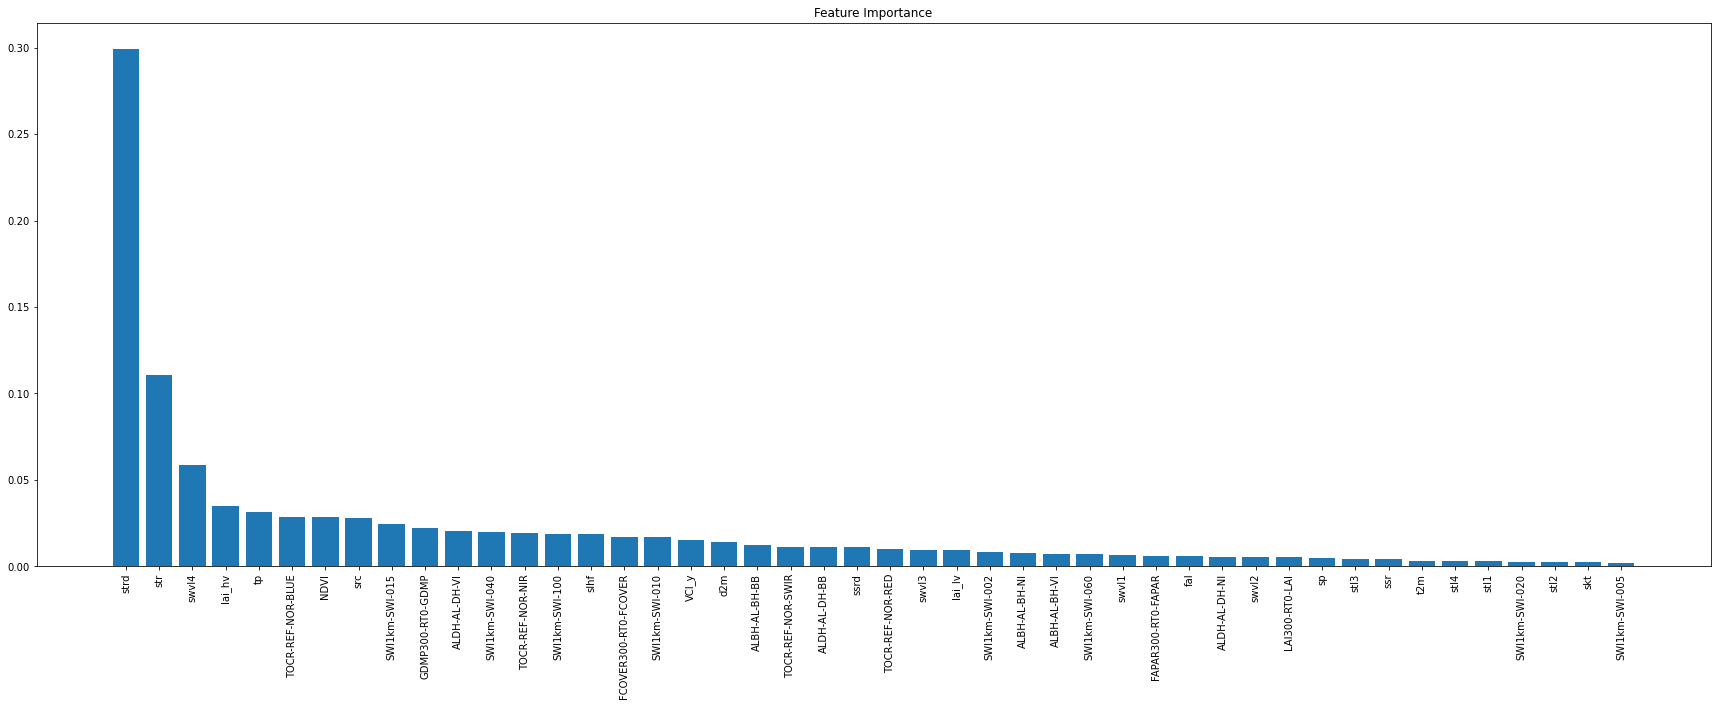

In [7]:
print('Feature importances: ')
np.set_printoptions(precision=2) #use 2 digit (decimal)
importances = clfXtrain.feature_importances_
print(importances)

feat_names = list(df.drop(columns=[regression_label]).columns.values) 

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
# Rearrange feature names so they match the sorted feature importances
names = [feat_names[i] for i in indices]
# Create plot
plt.figure(figsize=(30, 10))
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)
# Show plot
plt.show()

## Remove least important features

After determining the importance of each feature through random forest, removing the least important ones improves the performace of a single regression tree

In [6]:
# Select only the 30 most important features
num_feats = 30 # number of retained features
remove_f = names[:num_feats]

# Prepare the data
y = df[regression_label].values
# Select only the most important features in X
X = df.drop(columns=[regression_label])[remove_f].values #returns a numpy array
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# Normalize the data
X_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
# Test values have to be normalized with the training mean and std
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1)).ravel()
y_test = y_scaler.transform(y_test.reshape(-1, 1)).ravel()
y = y_scaler.transform(y.reshape(-1, 1)).ravel()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X = X_scaler.transform(X)
X_train.shape

(1619, 30)

### Train a decision tree with the remaining features

It is important to choose a good value for the max_depth of the tree, because trees too deep tend to overfit. So far the best result has been obtained with a max_depth of 7.

Regression Tree model score:  0.6015364664623324


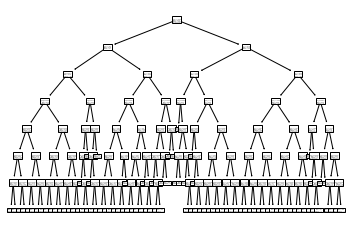

In [7]:
decision_tree = tree.DecisionTreeRegressor(max_depth=7)
decision_tree = decision_tree.fit(X_train,y_train)
print("Regression Tree model score: ", decision_tree.score(X_test, y_test))

plt.figure()
tree.plot_tree(decision_tree)
plt.show()

## Tree visualization

Once the graph has been exported to a .dot file, graphical renderings can be generated using, for example:
```
$ dot -Tpng tree.dot -o tree.png    (PNG format)
```

In [8]:
feat_names = list(df.drop(columns=[regression_label]).columns.values) 
dot_data = tree.export_graphviz(decision_tree,out_file='tree.dot',feature_names=remove_f, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)

### Dtreeviz visualization

Dtreeviz offers a great way to produce tree visualization with a lot of insight of how the mdoel takes decisions. 

In [9]:
from dtreeviz.trees import *
viz = dtreeviz(decision_tree,
               X_train,
               y_train,
               target_name='habitat_richness',
               feature_names=names)
viz.view()

## Prediction Path

The following visualization shows how the tree chooses a path when obtaining the regression. This kind of plot could be useful in a real-case scenario, because if the model makes a warning prediction it would be useful to understand the features it considered.

In [10]:
X = X_train[np.random.randint(0, len(X_train)),:]  # random sample from training

viz = dtreeviz(decision_tree,
               X_train,
               y_train,
               target_name='habitat_richness',
               orientation ='LR',  # left-right orientation
               feature_names=names,
               X=X)  # need to give single observation for prediction

viz.view()